# **Machine Learning para Recomenda√ß√£o de Jogos**

Projeto feito para o Tech Challenge da fase 3 do curso de Machine Learning Engineering, da FIAP.

Integrantes:
- Bruno Pinheiro Mendes
- Matheus Fonseca Chaves
- Michelle Da Luz Rodrigues
---


## Sobre o modelo de ML

Pelas regras da FIAP, o modelo **deve** alimentar algo (aplica√ß√£o, dashboard etc.), ent√£o decidimos criar um modelo capaz de, dado um jogo como entrada, recomendar jogos similares a ele.

O conjunto de dados utilizado foi o [Game Recommendations on Steam](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam), podendo ser acessado pela plataforma [Kaggle](https://kaggle.com).

## Configura√ß√µes do projeto

Para o projeto proposto, decidimos utilizar a API do Kaggle para obter os dados.

Para utilizar a API √© necess√°rio:
1. Ter o Kaggle instalado no sistema
2. Criar uma pasta chamada *.kaggle*
3. Baixar o arquivo *kaggle.json* no site do Kaggle e coloc√°-lo dentro da pasta *.kaggle*

Ap√≥s isso, utilizeremos a API para fazer o download e listagem do dataset alvo.

In [1]:
%pip install kaggle googletrans==4.0.0-rc1 scipy scikit-learn pandas seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Sobre os dados - An√°lise explorat√≥ria

O reposit√≥rio disponibiliza quatro conjuntos de dados:
- `games.csv`: informa√ß√µes sobre os jogos
- `games_metadata.json`: complementa os dados do arquivo acima, fornecendo mais dados sobre os jogos, como sua descri√ß√£o e suas tags
- `recommendations.csv`: avalia√ß√µes de usu√°rios dadas aos jogos
- `users.csv`: cont√©m a quantidade de jogos e reviews que o usu√°rio fez

Abaixo, iremos entender melhor sobre cada um deles.

### Carregando os dados

In [2]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [4]:
df_games = pd.read_csv('../data/games.csv')
df_games_metadata = pd.read_json('../data/games_metadata.json', lines=True)
df_recommendations = pd.read_csv('../data/recommendations.csv')
df_users = pd.read_csv('../data/users.csv')

### An√°lise de `games.csv`

In [6]:
print(f'O dataset cont√©m {df_games.shape[0]} linhas e {df_games.shape[1]} colunas')

O dataset cont√©m 50872 linhas e 454 colunas


Significado de cada uma das colunas:

- app_id - ID do jogo na Steam
- title - T√≠tulo do jogo
- date_release - Data de lan√ßamento (yyyy-mm-dd)
- win - O jogo possui suporte para Windows?
- mac- O jogo possui suporte para MacOS?
- linux - O jogo possui suporte para Linux?
- steam_deck - O jogo possui suporte para Steam Deck?
- rating - Categoria de avalia√ß√£o do jogo
- positive_ratio - Propor√ß√£o de feedbacks positivos
- user_reviews - Quantidade de avalia√ß√µes do jogo na p√°gina da Steam (ou seja, n√£o necessariamente o valor ir√° bater com o que temos no dataset `recommendations.csv`)
- price_original - Pre√ßo em USD calculado antes do desconto
- discount - Percentual de desconto
- price_final - Pre√ßo em USD calculado ap√≥s o desconto





In [7]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Columns: 454 entries, app_id to clean_description
dtypes: int64(449), object(5)
memory usage: 176.2+ MB


In [8]:
df_games.head(3)

app_id                              title  win  mac  linux  rating  \
0   13500  Prince of Persia: Warrior Within‚Ñ¢    1    0      0       7   
1   22364            BRINK: Agents of Change    1    0      0       6   
2  113020       Monaco: What's Yours Is Mine    1    1      1       7   

   positive_ratio  user_reviews  steam_deck  \
0              84          2199           1   
1              85            21           1   
2              92          3722           1   

                                         description  ... Western  Wholesome  \
0  Enter the dark underworld of Prince of Persia ...  ...       0          0   
1                                                NaN  ...       0          0   
2  Monaco: What's Yours Is Mine is a single playe...  ...       0          0   

   Word Game  World War I  World War II  Wrestling  Zombies  eSports  \
0          0            0             0          0        0        0   
1          0            0             0          0        0        0   
2          0            0             0          0        0        0   

                       clean_title  \
0  prince of persia warrior within   
1           brink agents of change   
2       monaco whats yours is mine   

                                   clean_description  
0  enter the dark underworld of prince of persia ...  
1                             brink agents of change  
2  monaco whats yours is mine is a single player ...  

[3 rows x 454 columns]

In [9]:
print(f'''H√° {df_games[df_games['app_id'] == 13500].user_reviews[0]} user_reviews na p√°gina do jogo na Steam,
mas apenas {df_recommendations[df_recommendations['app_id'] == 13500]['app_id'].count()} reviews deste mesmo jogo no dataset.''')

H√° 2199 user_reviews na p√°gina do jogo na Steam,
mas apenas 1686 reviews deste mesmo jogo no dataset.


In [10]:
df_games['rating'].unique()

array([7, 6, 4, 5, 8, 2, 3, 0, 1])

### An√°lise de `games_metadata.json`

In [11]:
print(f'O dataset cont√©m {df_games_metadata.shape[0]} linhas e {df_games_metadata.shape[1]} colunas')

O dataset cont√©m 50872 linhas e 3 colunas


Sobre suas colunas:

- app_id - ID do jogo na Steam
- description - Descri√ß√£o do jogo
- tags - G√™neros do jogo

In [12]:
df_games_metadata.sample(3)

app_id                                        description  \
30778  1815370  You need to build a team and get rewards throu...   
42576   808220  Virtual Reality survival rogue-like game based...   
45447  1849710                                                      

                                                    tags  
30778  [Casual, Turn-Based Strategy, Idler, Relaxing,...  
42576  [Indie, Early Access, Simulation, Adventure, A...  
45447  [Action, Adventure, RPG, Massively Multiplayer...

Na description podemos encontrar outros idiomas, caracteres especiais, textos mal escritos e/ou formatados e emojis. S√£o coisas que precisam ser levadas em conta caso o projeto utilize esta coluna.

Suas tags seguem o padr√£o da Steam, sendo assim, elas est√£o em ingl√™s e s√£o valores categ√≥ricos.

In [13]:
df_games_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_id       50872 non-null  int64 
 1   description  50872 non-null  object
 2   tags         50872 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [14]:
df_games_metadata[df_games_metadata['description'].str.strip() == '']

app_id description                                               tags
1        22364                                                       [Action]
7       271850              [Strategy, Simulation, Action, RTS, World War II]
18      245950              [Action, RPG, FPS, Co-op, Shooter, Action RPG,...
21      305181                                            [Adventure, Action]
30      458790                          [Adventure, Soundtrack, Visual Novel]
...        ...         ...                                                ...
50866  2362300                                                             []
50867  2296380                                                             []
50868  1272080                                                             []
50869  1402110                                                             []
50871  2488510                                                             []

[10373 rows x 3 columns]

In [15]:
df_games_metadata[df_games_metadata['tags'].apply(lambda x: x == [])]

app_id description tags
33      371970               []
214    2277010               []
219    1600150               []
224     222573               []
287     919640               []
...        ...         ...  ...
50866  2362300               []
50867  2296380               []
50868  1272080               []
50869  1402110               []
50871  2488510               []

[1244 rows x 3 columns]

In [16]:
game_tags_count = df_games_metadata['tags'].explode().value_counts().reset_index(name='count')
game_tags_count

tags  count
0            Indie  27957
1     Singleplayer  22566
2           Action  21897
3        Adventure  20183
4           Casual  17844
..             ...    ...
436     Volleyball     10
437      Hobby Sim      6
438  Tile-Matching      5
439            Fox      5
440         Coding      4

[441 rows x 2 columns]

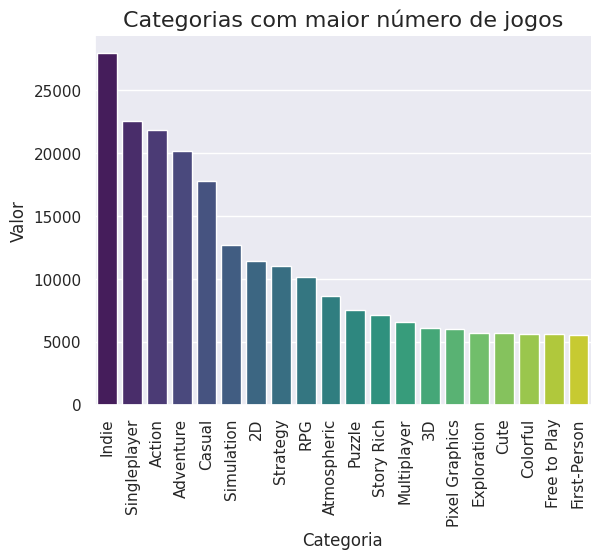

In [17]:
sns.set_theme()

# Criar o gr√°fico de barras
ax = sns.barplot(x='tags',
                 y='count',
                 hue='tags',
                 data=game_tags_count.nlargest(20, 'count'),
                 palette='viridis')

# Adicionar t√≠tulo e r√≥tulos
ax.set_title('Categorias com maior n√∫mero de jogos', fontsize=16)
ax.set_xlabel('Categoria', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)

# Rotacionar os r√≥tulos do eixo x para 90 graus
plt.xticks(rotation=90)

# Remover as bordas do gr√°fico
sns.despine()

# Exibir o gr√°fico
plt.show()

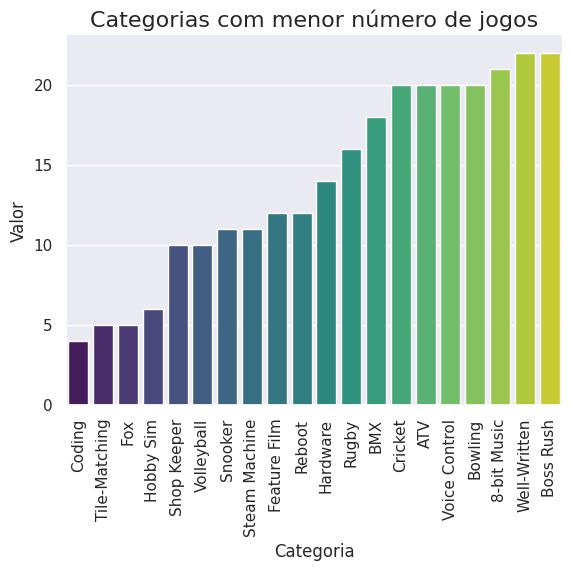

In [18]:
sns.set_theme()

# Criar o gr√°fico de barras
ax = sns.barplot(x='tags',
                 y='count',
                 hue='tags',
                 data=game_tags_count.nsmallest(20, 'count'),
                 palette='viridis')

# Adicionar t√≠tulo e r√≥tulos
ax.set_title('Categorias com menor n√∫mero de jogos', fontsize=16)
ax.set_xlabel('Categoria', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)

# Rotacionar os r√≥tulos do eixo x para 90 graus
plt.xticks(rotation=90)

# Remover as bordas do gr√°fico
sns.despine()

# Exibir o gr√°fico
plt.show()

Temos 411 categorias diferentes, futuramente, podemos tentar realizar um trabalho para tentar agrup√°-las em categorias similares tamb√©m, a fim de reduzir este n√∫mero.

Al√©m disso, ambas as colunas apresentam valores vazios - o texto vazio para 'description' e uma lista vazia para 'tags'. Ou seja, n√£o podemos depender apenas destes valores para recomendar um jogo.

### An√°lise de `recommendations.csv`

Sobre suas colunas:

- app_id - ID do jogo na Steam
- helpful - Quantidade indicando se a avalia√ß√£o foi marcada como √∫til
- funny - Quantidade indicando se a avalia√ß√£o foi marcada como engra√ßada
- date - Data que a avalia√ß√£o foi postada (yyyy-mm-dd)
- is_recommended - Indica se a avalia√ß√£o est√° recomendando o jogo ou n√£o
- hours - Quantidade de horas jogadas pelo usu√°rio que postou a avalia√ß√£o
- user_id - O id do usu√°rio
- review_id - O id da avalia√ß√£o

A tabela de recomenda√ß√µes √© a maior dentre as que temos. Por mais que n√£o tenah tantas colunas, apresenta um grande n√∫mero de linhas.

In [19]:
print(f'O dataset cont√©m {df_recommendations.shape[0]} linhas e {df_recommendations.shape[1]} colunas')

O dataset cont√©m 41154794 linhas e 8 colunas


In [20]:
df_recommendations.sample(3)

app_id  helpful  funny        date  is_recommended  hours  \
30269366      130        0      0  2020-10-16            True    5.8   
13689     1250410        0      0  2020-08-22            True  330.7   
15964849  2087030        2      0  2022-09-17           False   79.6   

           user_id  review_id  
30269366  12193728   30269366  
13689      8073182      13689  
15964849   8715090   15964849

In [21]:
df_recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


Sendo uma tabela que indica as avalia√ß√µes dos usu√°rios, para o nosso caso (recomenda√ß√£o), precisamos ter um maior cuidado caso existam avalia√ß√µes repetidas, pois isso pode influenciar no resultado final.

J√° para o resto das colunas, elas ir√£o representar valores auxiliares na recomenda√ß√£o, dando mais ou menos for√ßa para representar o qu√£o bom o jogo √©, principalmente a is_recommended e hours.

In [22]:
len(df_recommendations['review_id'].unique())

41154794

### An√°lise de `users.csv`

Sobre suas colunas:

- user_id - O id do usu√°rio
- products - Quantidade de jogos que possui na conta
- reviews - Quantidade de reviews feitas

In [23]:
df_users.sample(10)

user_id  products  reviews
8872325     429877       446        1
512629    13164767       151        1
6351230   13344885         2        1
8949247   11448854       113        3
5586061    6083584       151        1
551165    12692581        37        1
1691072    9965948        36        1
12784607  13401671        14        1
1788785    3716188        43        1
2618422    9463927        43        2

Os usu√°rios daqui podem ser relacionados com a tabela de avalia√ß√µes. As colunas `products` e `reviews` podem ajudar a criar uma m√©trica que consiga indicar uma maior relev√¢ncia para suas avalia√ß√µes.\
Ex.: um usu√°rio que possui muitos produtos na conta e muitas reviews, provavelmente √© uma pessoa com um perfil mais s√©rio, portanto, sua avalia√ß√£o poderia ser levada mais em conta do que outros usu√°rios.

In [24]:
display(df_users.sort_values(by='products', ascending=False))
display(df_users.sort_values(by='reviews', ascending=False))

user_id  products  reviews
9737072   11686938     32214       12
9447859    9970555     30124       10
13807061   6238999     30108       91
2261507    9617880     29752      107
4656255    9895433     29655        2
...            ...       ...      ...
7356753     533746         0        1
7356750     533285         0        1
14305996   4939976         0        0
14305966   4899806         0        0
14305965   4899666         0        0

[14306064 rows x 3 columns]

user_id  products  reviews
4803549   11764552      7898     6045
9965497    5112758      1226     4152
13741354  11656130      1807     3840
12041089   5669734      4737     3479
8734053   11553593      1919     3392
...            ...       ...      ...
14306039   4979144        24        0
14306038   4978747         3        0
14306037   4977291        12        0
14306036   4975288        18        0
14306035   4973520        28        0

[14306064 rows x 3 columns]

# Como a recomenda√ß√£o ser√° feita?

No final do projeto, queremos que o usu√°rio escolha um jogo e receba recomenda√ß√µes de outros jogos similares.

Primeiramente, temos que definir o que far√° um jogo ser recomendado.\
Temos alguns caminhos poss√≠veis, mas imaginando como um produto real, o que os usu√°rios mais querem √© receber recomenda√ß√µes de jogos **no m√≠nimo** com uma **jogabilidade** parecida.

Por√©m um jogo possui v√°rios outros atributos, como:
- Estilo/jogabilidade;
- Nota - se o jogo √© bem avaliado;
- Popularidade - se o jogo √© conhecido;
- Pre√ßo

Com isso em mente, definimos um caminho para criar o modelo, sendo, inicialmente:
- O m√≠nimo que queremos √© que o algoritmo recomende jogos com um estilo/jogabilidade parecida
    - Ou seja, h√° bastante "peso" nas colunas de nome, descri√ß√£o e g√™nero do jogo, pois elas ser√£o, provavelmente, os maiores indicadores de jogos parecidos
- N√£o iremos utilizar o pre√ßo e data de lan√ßamento no modelo
    - N√£o faz sentido que um jogo seja recomendado devido ao pre√ßo dele, portanto, na prepara√ß√£o dos dados, iremos remov√™-lo
    - N√£o queremos que um jogo tenha mais chances de ser similar a outro por seu pre√ßo ou data de lan√ßamento
- Uma das formas de recomenda√ß√£o √© encontrar usu√°rios com os mesmos gostos, ent√£o tamb√©m podemos tentar levar isso em conta
    - Esse tipo de recomenda√ß√£o √© mais √∫til quando temos uma conta ativa sendo utilizada, que n√£o √© o caso do nosso projeto
    - Ainda assim, podemos tentar utilizar o perfil dos usu√°rios como um tipo de indicador de confian√ßa. Ex.: usu√°rios com mais jogos e avalia√ß√µes, provavelmente far√£o um julgamento melhor do jogo

No final, dado um jogo como input para o modelo, ele deve recomendar outros jogos que sejam similares em jogabilidade e, possivelmente, tamb√©m populares.

> Exemplo: Caso o jogo de input seja "Doom (1993)", seria interessante que outros jogos da mesma franquia fossem recomendados (devido a similaridade no nome, descri√ß√£o e jogabilidade), mas caso um destes n√£o seja t√£o popular, um outro jogo parecido com Doom poderia entrar na lista de recomendados, como "Wolfenstein 3D" ou outros jogos do mesmo g√™nero.

# Prepara√ß√£o dos dados (pr√©-processamento)

Aqui o objetivo √© tratar e modificar os dados, a fim de uma melhor utiliza√ß√£o em nosso modelo de ML.

### Removendo colunas desnecess√°rias

Conforme j√° falado acima, n√£o queremos a influ√™ncia do pre√ßo e nem de datas no modelo, portanto podemos remover essas coluna para deixar a base menor

In [4]:
df_games.head(1)

app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within‚Ñ¢   2008-11-21  True  False  False   

          rating  positive_ratio  user_reviews  price_final  price_original  \
0  Very Positive              84          2199         9.99            9.99   

   discount  steam_deck  
0       0.0        True

In [5]:
df_games.drop(columns=['date_release', 'price_final', 'price_original', 'discount'], inplace=True)
df_games.head(1)

app_id                              title   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within‚Ñ¢  True  False  False   

          rating  positive_ratio  user_reviews  steam_deck  
0  Very Positive              84          2199        True

### Tratando valores categ√≥ricos

Queremos utilizar alguns campos de texto na an√°lise, como o t√≠tulo, descri√ß√£o e g√™neros do jogo, por√©m o resto dos campos pode ser transformado diretamente em n√∫meros

#### Coluna rating

Como as notas funcionam na Steam?

In [5]:
df_games.rating.unique()

array(['Very Positive', 'Positive', 'Mixed', 'Mostly Positive',
       'Overwhelmingly Positive', 'Negative', 'Mostly Negative',
       'Overwhelmingly Negative', 'Very Negative'], dtype=object)

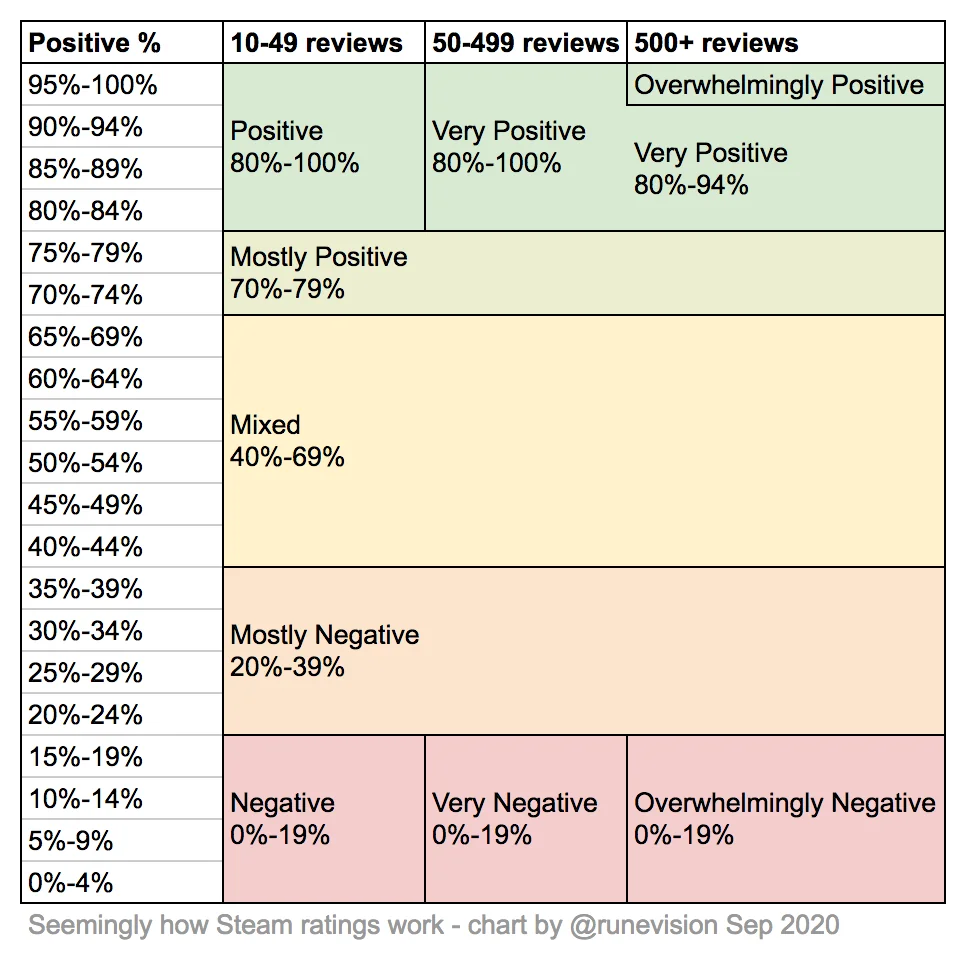

Por mais que o usu√°rio apenas consiga recomendar ou n√£o um jogo, pela imagem acima, percebe-se que temos 9 poss√≠veis notas finais, que dependem tanto da avalia√ß√£o do usu√°rio quanto da quantidade total de avalia√ß√µes que o jogo recebeu. Ou seja, al√©m de ser um √≠ndice de qualidade, tamb√©m indica popularidade.

Como as notas possuem uma ordem, decidimos transformar as categorias seguindo a ordem acima:

In [6]:
ratings_encoding = {
    'Overwhelmingly Negative': 0,
    'Very Negative': 1,
    'Negative': 2,
    'Mostly Negative': 3,
    'Mixed': 4,
    'Mostly Positive': 5,
    'Positive': 6,
    'Very Positive': 7,
    'Overwhelmingly Positive': 8
}

df_games['rating'] = df_games['rating'].map(ratings_encoding)
df_games.rating.unique()

array([7, 6, 4, 5, 8, 2, 3, 0, 1])

In [7]:
df_games[['rating', 'positive_ratio', 'user_reviews']]

rating  positive_ratio  user_reviews
0           7              84          2199
1           6              85            21
2           7              92          3722
3           4              61           873
4           7              88          8784
...       ...             ...           ...
50867       7              96           101
50868       3              38         29458
50869       7              89          1128
50870       7              95            82
50871       7              88           144

[50872 rows x 3 columns]

Nos datasets temos colunas que indicam claramente a popularidade do jogo, mas podemos tentar analis√°-las para criar novos indicadores.

#### Colunas sobre as plataformas que o jogo suporta

Todas elas possuem valores booleanos indicando se o jogo possui ou n√£o suporte √†quela plataforma. Sendo assim, apenas irei alterar para:
- 0: n√£o possui suporte
- 1: possui suporte

In [8]:
# visualizando os valores nas colunas, para garantir que apenas possuem True e False
df_games[['win', 'mac', 'linux', 'steam_deck']].apply(lambda x: x.unique())

win    mac  linux  steam_deck
0   True  False  False        True
1  False   True   True       False

In [9]:
df_games[['win', 'mac', 'linux', 'steam_deck']].head(1)

win    mac  linux  steam_deck
0  True  False  False        True

In [10]:
df_games[['win', 'mac', 'linux', 'steam_deck']] = df_games[['win', 'mac', 'linux', 'steam_deck']].astype(int)
df_games[['win', 'mac', 'linux', 'steam_deck']].head(1)

win  mac  linux  steam_deck
0    1    0      0           1

### Tratando valores num√©ricos abertos

O positive_ratio n√£o parece precisar de tratamentos, pois vai de 0 at√© 100, representando uma porcentagem. Al√©m disso, sua distribui√ß√£o segue um padr√£o s√≥lido:

M√≠nimo de ratio: 0
M√°ximo de ratio: 100
Distribui√ß√£o de ratio: Axes(0.125,0.11;0.775x0.77)


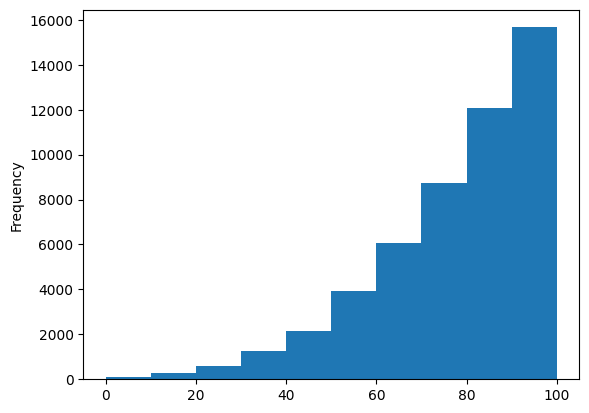

In [11]:
print(f'M√≠nimo de ratio: {df_games.positive_ratio.min()}')
print(f'M√°ximo de ratio: {df_games.positive_ratio.max()}')
print(f'Distribui√ß√£o de ratio: {df_games.positive_ratio.plot(kind="hist")}')

J√° as user_reviews servem como um √≠ndice de popularidade do jogo, mostrando o quanto o jogo √© popular. N√£o precisamos tratar este campo tamb√©m, j√° que a an√°lise demonstrou que apenas h√° n√∫meros e n√£o temos nulos

In [12]:
df_games.user_reviews.describe()

count    5.087200e+04
mean     1.824425e+03
std      4.007352e+04
min      1.000000e+01
25%      1.900000e+01
50%      4.900000e+01
75%      2.060000e+02
max      7.494460e+06
Name: user_reviews, dtype: float64

A distribui√ß√£o do n√∫mero de reviews √© "ruim", pois poucos jogos (comparados ao n√∫mero do dataset) se destacam muito mais do que outros.

Ainda assim, provavelmente n√£o ser√° um problema, j√° que isso apenas pode ser utilizado, no nosso caso, para definir a popularidade do jogo e/ou qualidade das avalia√ß√µes dadas.

In [13]:
df_games[['title', 'user_reviews']].sort_values(by='user_reviews', ascending=False).head(10)

title  user_reviews
14398  Counter-Strike: Global Offensive       7494460
47770               PUBG: BATTLEGROUNDS       2217226
13176                            Dota 2       2045628
12717                Grand Theft Auto V       1484122
14535   Tom Clancy's Rainbow Six¬Æ Siege        993312
47380                   Team Fortress 2        985819
13035                          Terraria        943413
15363                       Garry's Mod        853733
13173                              Rust        786668
14376                     Apex Legends‚Ñ¢        713182

<Axes: ylabel='Frequency'>

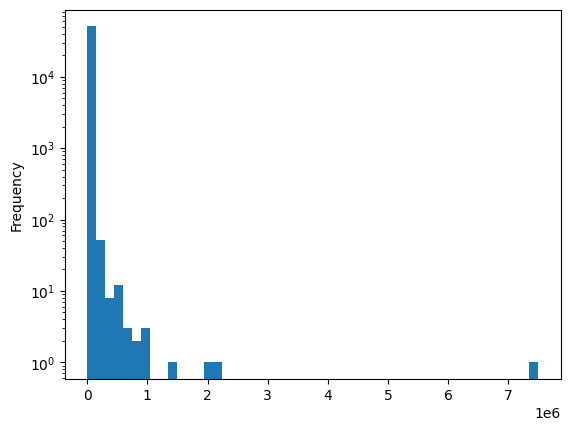

In [14]:
df_games.user_reviews.plot(kind='hist', bins=50, logy=True)

### Lidando com os textos

#### Inserindo description e tags na `df_games`

Conforme dito anteriormente, h√° tr√™s colunas de texto importantes quando o assunto √© assimilar um jogo com outro:
- T√≠tulo
- Descri√ß√£o
- G√™neros

Ent√£o iremos incluir as colunas de g√™nero descri√ß√£o em nossa tabela.

In [5]:
df_games[df_games['app_id'] == 13500]

app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within‚Ñ¢   2008-11-21  True  False  False   

          rating  positive_ratio  user_reviews  price_final  price_original  \
0  Very Positive              84          2199         9.99            9.99   

   discount  steam_deck  
0       0.0        True

In [6]:
df_games_metadata[df_games_metadata['app_id'] == 13500]

app_id                                        description  \
0   13500  Enter the dark underworld of Prince of Persia ...   

                                                tags  
0  [Action, Adventure, Parkour, Third Person, Gre...

In [7]:
print(f'O tamanho das bases √© igual? {len(df_games) == len(df_games_metadata)}')

O tamanho das bases √© igual? True


In [8]:
df_games = pd.merge(df_games, df_games_metadata, on='app_id', how='inner')
df_games[df_games['app_id'] == 13500]

app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within‚Ñ¢   2008-11-21  True  False  False   

          rating  positive_ratio  user_reviews  price_final  price_original  \
0  Very Positive              84          2199         9.99            9.99   

   discount  steam_deck                                        description  \
0       0.0        True  Enter the dark underworld of Prince of Persia ...   

                                                tags  
0  [Action, Adventure, Parkour, Third Person, Gre...

#### Tratando as tags (g√™neros)

Por mais que as tags sejam valores categ√≥ricos, temos duas alternativas:
- Junt√°-las as outras colunas de texto
- Realizar o one-hot encoding

N√£o sabemos qual ir√° resultar no melhor modelo, portanto, iremos tentar as duas alternativas

**One-hot encoding das categorias**

In [9]:
tags_dummies = pd.get_dummies(df_games['tags'].explode()).groupby(level=0).sum()
tags_dummies

1980s  1990's  2.5D  2D  2D Fighter  2D Platformer  360 Video  3D  \
0          0       0     0   0           0              0          0   0   
1          0       0     0   0           0              0          0   0   
2          0       0     0   1           0              0          0   0   
3          0       0     0   0           0              0          0   0   
4          0       0     0   1           0              0          0   0   
...      ...     ...   ...  ..         ...            ...        ...  ..   
50867      0       0     0   0           0              0          0   0   
50868      0       0     0   0           0              0          0   0   
50869      0       0     0   0           0              0          0   0   
50870      0       0     0   0           0              0          0   1   
50871      0       0     0   0           0              0          0   0   

       3D Fighter  3D Platformer  ...  Well-Written  Werewolves  Western  \
0               0              0  ...             0           0        0   
1               0              0  ...             0           0        0   
2               0              0  ...             0           0        0   
3               0              0  ...             0           0        0   
4               0              0  ...             0           0        0   
...           ...            ...  ...           ...         ...      ...   
50867           0              0  ...             0           0        0   
50868           0              0  ...             0           0        0   
50869           0              0  ...             0           0        0   
50870           0              0  ...             0           0        0   
50871           0              0  ...             0           0        0   

       Wholesome  Word Game  World War I  World War II  Wrestling  Zombies  \
0              0          0            0             0          0        0   
1              0          0            0             0          0        0   
2              0          0            0             0          0        0   
3              0          0            0             0          0        1   
4              0          0            0             0          0        0   
...          ...        ...          ...           ...        ...      ...   
50867          0          0            0             0          0        0   
50868          0          0            0             0          0        0   
50869          0          0            0             0          0        0   
50870          0          0            0             0          0        0   
50871          0          0            0             0          0        0   

       eSports  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
50867        0  
50868        0  
50869        0  
50870        0  
50871        0  

[50872 rows x 441 columns]

In [21]:
df_games = pd.concat([df_games, tags_dummies], axis=1)
df_games.sample(5)

app_id                                         title date_release  \
38559  1047150  LAMUNATION! -international- Vocal Collection   2019-12-04   
49670  1344120                                   Bistro Days   2022-02-25   
14806   237800               Remember Me: Combo Lab Pack DLC   2013-08-23   
46548  2295390                               Mr. Mat Hematic   2023-02-26   
46972  1942450                                      Gemlands   2022-04-09   

       win  mac  linux  rating  positive_ratio  user_reviews  price_final  \
38559    1    0      0       6             100            14         0.99   
49670    1    1      0       6             100            10         7.79   
14806    1    0      0       5              72            58         3.99   
46548    1    0      0       5              79            53         0.00   
46972    1    0      0       6              80            10         0.99   

       ...  Well-Written  Werewolves  Western Wholesome Word Game  \
38559  ...             0           0        0         0         0   
49670  ...             0           0        0         0         0   
14806  ...             0           0        0         0         0   
46548  ...             0           0        0         0         0   
46972  ...             0           0        0         0         0   

       World War I  World War II  Wrestling  Zombies  eSports  
38559            0             0          0        0        0  
49670            0             0          0        0        0  
14806            0             0          0        0        0  
46548            0             0          0        0        0  
46972            0             0          0        0        0  

[5 rows x 456 columns]

Validando se o hot-encoding funcionou corretamente:

In [22]:
# Todas as colunas que aparecerem no array abaixo devem possuir o n√∫mero 1 como valor
genres_2272250 = df_games[df_games['app_id'] == 2272250]['tags'].values[0]
print(genres_2272250)
df_games.loc[df_games['app_id'] == 2272250, genres_2272250]

['Early Access', 'FPS', 'Action', 'Retro', 'First-Person', 'Lovecraftian', 'Atmospheric', '3D', 'Shooter', 'Singleplayer', 'Old School', 'Horror', 'Violent', 'Combat', 'Cartoony', 'Stylized', 'Psychedelic', 'Gore', 'Adventure', 'Character Customization']


Early Access  FPS  Action  Retro  First-Person  Lovecraftian  \
50870             1    1       1      1             1             1   

       Atmospheric  3D  Shooter  Singleplayer  Old School  Horror  Violent  \
50870            1   1        1             1           1       1        1   

       Combat  Cartoony  Stylized  Psychedelic  Gore  Adventure  \
50870       1         1         1            1     1          1   

       Character Customization  
50870                        1

In [23]:
(df_games.loc[df_games['app_id'] == 2272250, genres_2272250].values == 1).all()

np.True_

#### Tratando `title` e `description`

Estas colunas possuem caracteres diferentes dos latinos, sendo necess√°rio ter certeza que os tratamentos de encoding ir√£o funcionar nelas de forma adequada.

Uma boa abordagem pode ser identificar algumas linhas assim e depois checar se estes √≠ndices foram transformados corretamente

In [25]:
non_ascii_regex = r'[^\x00-\x7F]+'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
#     display(df_games[df_games['title'].str.contains(non_ascii_regex, regex=True) |
#                      df_games['description'].str.contains(non_ascii_regex, regex=True)][['title', 'description']])

df_games[df_games['title'].str.contains(non_ascii_regex, regex=True) |
         df_games['description'].str.contains(non_ascii_regex, regex=True)][['title', 'description']].sample(10)

title  \
16417                       Riders Republic‚Ñ¢ Year 1 Pass   
29743                                          Ookibloks   
35526   ACE COMBAT‚Ñ¢ 7: SKIES UNKNOWN - ADF-01 FALKEN Set   
47090  ACE COMBAT‚Ñ¢ 7: SKIES UNKNOWN 25th Anniversary ...   
13843                               PBA Pro Bowling 2023   
40357                                           Dog Duty   
38749                                Drawn‚Ñ¢: Dark Flight   
2813                                          Night Call   
15556                                       EverQuest II   
18116                       [Chilla's Art] Hanako | Ëä±Â≠ê„Åï„Çì   

                                             description  
16417                                                     
29743  Ookibloks combines the spirit of classic actio...  
35526                                                     
47090                                                     
13843  The ultimate bowling game is back with PBA Pro...  
40357  As some evil bigwig Octopus Commander and his ...  
38749  A kingdom‚Äôs future rests in the light of three...  
2813   Friend. Confidant. Therapist. Voyeur. As a cab...  
15556  EverQuest¬Æ II is the epitome of massively mult...  
18116  Hanako | Ëä±Â≠ê„Åï„Çì is a Japanese survival horror ad...

Analisando os t√≠tulos e descri√ß√µes acima, percebemos algumas coisas:
- H√° descri√ß√µes vazias
- Temos idiomas diferentes do ingl√™s, como no jogo "È¢®Ëâ≤ÂπªÊÉ≥5:Ëµ§ÊúàÊà∞Áà≠", onde seu t√≠tulo e descri√ß√£o est√£o em chin√™s. Logo, precisamos ter cuidado ao tratar estes caracteres para n√£o apagar totalmente o jogo.
- Nos t√≠tulos temos muitos caracteres especiais, que muitas vezes n√£o aparecem na descri√ß√£o do jogo.
    - Ex.: "Prince of Persia: Warrior Within‚Ñ¢" h√° o caractere "‚Ñ¢" no t√≠tulo, mas ele n√£o aparece na descri√ß√£o
    - Nesses casos, seria interessante remover o caractere especial, a fim de criar um t√≠tulo mais pr√≥ximo da descri√ß√£o
- Nas descri√ß√µes, muitas vezes temos emojis, algumas vezes entre os textos, como no jogo "Dinky Guardians". Talvez isso atrapalhe na rela√ß√£o dos textos, ent√£o seria interessante remover todos os emojis.
    - Ex.: As descri√ß√µes "Build a üöÄRocket" e "Build a Rocket" s√£o iguais, por√©m o emoji no meio pode distanciar seu significado no algoritmo, prejudicando o modelo de encontrar a similaridade entre as descri√ß√µes

##### Tratamento geral dos textos

Remover emojis, deixar tudo min√∫sculo, remo√ß√£o de caracteres especiais, etc.

In [26]:
def contains_chinese(text):
    chinese_char_pattern = re.compile(r'[\u4e00-\u9fff]+')
    return bool(chinese_char_pattern.search(text))


def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # S√≠mbolos e pictogramas
        "\U0001F680-\U0001F6FF"  # S√≠mbolos de transporte e mapas
        "\U0001F1E0-\U0001F1FF"  # Bandeiras (alfabeto regional)
        "\U00002500-\U00002BEF"  # Setas e s√≠mbolos variados
        "\U00002702-\U000027B0"  # Outros tipos de s√≠mbolos e pictogramas
        "\U000024C2-\U0001F251"  # Diversos s√≠mbolos extras
        "\U0001F900-\U0001F9FF"  # S√≠mbolos e pictogramas de extens√£o
        "\U0001FA70-\U0001FAFF"  # Novos pictogramas e s√≠mbolos adicionais
        "\U00002600-\U000026FF"  # Diversos s√≠mbolos como ‚òÄÔ∏è, ‚õÖ, ‚òÅÔ∏è
        "\U0001F7E0-\U0001F7FF"  # Quadrados coloridos, etc.
        "\U0001F780-\U0001F7D8"  # C√≠rculos e quadrados coloridos
        "]+", flags=re.UNICODE)

    if (contains_chinese(text)):
        emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # S√≠mbolos e pictogramas
        "\U0001F680-\U0001F6FF"  # S√≠mbolos de transporte e mapas
        "\U0001F1E0-\U0001F1FF"  # Bandeiras (alfabeto regional)
        "\U0001F900-\U0001F9FF"  # S√≠mbolos e pictogramas de extens√£o
        "\U0001FA70-\U0001FAFF"  # Novos pictogramas e s√≠mbolos adicionais
        "\U0001F7E0-\U0001F7FF"  # Quadrados coloridos, etc.
        "\U0001F780-\U0001F7D8"  # C√≠rculos e quadrados coloridos
        "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text).strip().lower()


def remove_special_chars(text):
    special_char_pattern = re.compile(r'[‚Ñ¢¬©¬Æ¬ô‚Ä¶<>#$%^&*+=\[\]{}|\\/~`.,;:!?\'\"()/]')
    return special_char_pattern.sub(r'', text)

df_games['clean_title'] = df_games['title'].apply(lambda x: remove_emojis(remove_special_chars(x)))
df_games['clean_description'] = df_games['description'].apply(lambda x: remove_emojis(remove_special_chars(x)))

In [27]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df_games[df_games['title'].str.contains(non_ascii_regex, regex=True) |
                     df_games['description'].str.contains(non_ascii_regex, regex=True)][['title', 'clean_title', 'description', 'clean_description']].sample(10))

title  \
7639   Gunvolt Chronicles: Luminous Avenger iX - Extra Song: 'Raison d'√™tre'   
1975                                      Nancy Drew¬Æ: The Phantom of Venice   
5259                                                                  Koloro   
25471                                                    HORGIHUGH („Éõ„Éº„ÇÆ„Éº„Éí„É•„Éº)   
36034                                                       Map Of Materials   
2798                                                              Tabletopia   
19059                                       AKIBA'S TRIP: Undead ÔºÜ Undressed   
37218                                                   Let Hawaii Happen VR   
10048                                 In the Raven Shadow ‚Äì Ve st√≠nu havrana   
6093                                                              ILLUMINATI   

                                                            clean_title  \
7639   gunvolt chronicles luminous avenger ix - extra song raison d√™tre   
1975                                   nancy drew the phantom of venice   
5259                                                             koloro   
25471                                                         horgihugh   
36034                                                  map of materials   
2798                                                         tabletopia   
19059                                     akibas trip undead  undressed   
37218                                              let hawaii happen vr   
10048                            in the raven shadow ‚Äì ve st√≠nu havrana   
6093                                                         illuminati   

                                                                                                                                                                                                                                                                                                        description  \
7639                                                                                                                                                                                                                                                                                                                  
1975                                                                                                                                                                                                                                                                  Infiltrate a Carnevale of Criminals in Italy!   
5259                                                                                                    Between dreams and nightmares, ‚ÄúKoloro‚Äù tells the tale of a young pink hair girl named Kora who embarks on a quest to find her missing sister through a stunning Puzzle-Platformer crafted by Sk√∂ll Studio.   
25471                                                                                   HORGIHUGH is a horizontal side-scrolling shoot 'em up from Japanese developer PiXEL featuring vibrant retro graphics, intense boss battles, a unique power-up system, and an adorable roster of anthropomorphic characters.   
36034                                                                                                                 In "Map Of Materials", Vincent‚Äôs exciting adventure awaits you. You find him stranded on a mysterious island where he uses all his skills and knowledge to escape and return to his old life.   
2798                                                      Tabletopia is a sandbox virtual table with high-quality board games and ready setups. Already 2000+ games and counting! Play how you want with whom you want: guests don‚Äôt need accounts to play. Or make your own games, no programming skills required.   
19059             In Tokyo‚Äôs popular ‚ÄùElectric Town‚Äù district, Akihabara, vampires called ‚ÄúSynthisters‚Äù walk among us. You must identify and di

##### Traduzindo os textos

Em alguns casos, o t√≠tulo e/ou descri√ß√£o do jogo √© composto pelo nome em ingl√™s e outro idioma, nesses casos, n√£o h√° problema, pois o algoritmo ir√° conseguir associar a similaridade dos textos.

Exemplo: o t√≠tulo "*–®–•–î: –ó–ò–ú–ê / IT'S WINTER*" cont√©m texto em ingl√™s, sendo identific√°vel em outros textos em ingl√™s, facilitando a busca pelo algoritmo. J√° o t√≠tulo "ÂªÉÁóÖÈô¢Êé¢Á¥¢" √© totalmente em outro idioma, n√£o sendo identificado com o ingl√™s.

Por conta disso, decidimos traduzir os t√≠tulos e descri√ß√µes que s√£o totalmente compostos por caracteres n√£o-latinos.

In [28]:
# regex que inclui caracteres n√£o-latinos com exce√ß√£o de pontua√ß√µes e n√∫meros
non_ascii_full_regex = r'^[^\x00-\x7F\d.,:;!?\'"()\-‚Äì‚Ä¶\s]+[\d.,:;!?\'"()\-‚Äì‚Ä¶\s]*$'

df_games[df_games['clean_title'].str.match(non_ascii_full_regex, na=False) |
         df_games['clean_description'].str.match(non_ascii_full_regex, na=False)][['clean_title', 'clean_description']]

clean_title  \
355    bishojo mangekyo kotowari to meikyu no shojo   
401                                           ÁåéÈ≠îËÄÖÊàòÁ∫™   
408                                             È£é‰ø°Ê•º   
424                Ëä±ËêΩÂÜ¨ÈôΩ snowdreams -lost in winter-   
553                                              Â§©Â∏à   
...                                             ...   
50601                                         ÂªÉÁóÖÈô¢Êé¢Á¥¢   
50602                                            Á•ûÊõ≤   
50660                                      ÈæôÂÇ≤Â§©ÁöÑÂ§öÂÖÉÂÆáÂÆô   
50704                                   ÂçàÂâç‰∫îÊôÇ„Å´„Éî„Ç¢„Éé„ÇíÂºæ„Åè   
50754                                          Ê∏∏Èæô‰º†ËØ¥   

                                       clean_description  
355    Áé©ÂÆ∂Â∞ÜÂíåÊïÖ‰∫ã‰∏≠ÊÄßÊ†ºÂêÑÂºÇÁöÑËßíËâ≤‰∏ÄËµ∑ÔºåËß£ÂºÄÁ•ûÁßòË∂ÖËá™ÁÑ∂‰∫ã‰ª∂ÁöÑÁúüÁõ∏„ÄÇÂπ∂ÈÄêÊ≠•‰∫ÜËß£Ë¥ØÁ©øÊï¥ÈÉ®Ê∏∏ÊàèÁöÑÊ†∏ÂøÉ‚Äî‚Äî...  
401                ËøôÊòØ‰∏ÄÊ¨æËΩªÊùæ‰ºëÈó≤ÁöÑËßíËâ≤ÊâÆÊºîÊ∏∏ÊàèÔºåÂíåÁ±≥Â®Ö‰∏ÄËµ∑ÂÜíÈô©ÔºåÂèëÁé∞Ê∑±ËóèÂú®ÁéãÂõΩÊ∑±Â§ÑÁöÑÁßòÂØÜ„ÄÇ  
408    ÊòèÂêõËØØÂõΩÔºåÊÄ®Â£∞ËΩΩÈÅìÔºåÊó†Êï∞ÈáéÂøÉÂÆ∂ÊöóËµ∑ÂèçÂøÉ„ÄÇÂú®‰∫¨Âüé‰∏ÄÂÆ∂ÈùíÊ•ºÁöÑÊé©È•∞‰∏ãÔºå‰Ω†ÂüπÂÖªÊâã‰∏ã„ÄÅÁßØÊîíÈí±Ë¥¢„ÄÅÊî∂ÈõÜÊÉÖ...  
424    „ÄäËä±ËêΩÂÜ¨ÈôΩ„ÄãÊòØ‰∏ÄÊ¨æ‰ª•„ÄåÂ§¢ÊÉ≥„ÄçËàá„ÄåÊÄùÂøµ„ÄçÁÇ∫‰∏ªÈ°åÁöÑÊñáÂ≠óÂÜíÈö™ÈÅäÊà≤„ÄÇÊïÖ‰∫ãË¨õËø∞‰∏ªËßíË¨ùÂ≠êËá£Âú®ËøΩÂ∞ã‰ΩúÂÆ∂‰πãÂ§¢...  
553    „ÄäÂ§©Â∏à„ÄãÊòØ‰∏ÄÊ¨æ‰ª•‰∏≠ÂõΩ‰øÆÁúüÊñáÂåñÂíåÈ¨ºÊÄ™‰º†ËØ¥‰∏∫È¢òÊùêÁöÑÁã¨Á´ãÊ∏∏ÊàèÔºå‰πüÊòØÊàë‰ª¨Âõ¢ÈòüÁöÑÁ¨¨‰∫åÊ¨æÊ∏∏Êàè„ÄÇÁé©ÂÆ∂Â∞ÜÊâÆÊºî...  
...                                                  ...  
50601  this is a horror game that asks a friend to fi...  
50602                                          ÂçÅÂπ¥ÁªèÂÖ∏rpgÂ§ß‰Ωú  
50660  this is a role-playing game in which players p...  
50704  piano at 5 am is a short text adventure game a...  
50754                                  Ë∏è‰ªôË∑ØÔºåÊ∏∏ÂõõÊµ∑Ôºå‰∏äÂè§Á•ûÂÖΩÔºåÂºÄÊîæ‰∏ñÁïå  

[615 rows x 2 columns]

In [29]:
from googletrans import Translator
import time

translator = Translator()

def translate_text(text, retries=5):
    attempt = 0
    while attempt < retries:
        try:
            translator.raise_Exception = True
            translated_text = translator.translate(text, dest='en').text
            time.sleep(1)
            return remove_special_chars(f'{translated_text} ({text})').strip().lower()
        except BaseException as error:
            if '429' in str(error):
                print(f'Erro 429 detectado. Tentando novamente ap√≥s espera...\nTentativa {attempt+1}/{retries}')
                time.sleep(5 + attempt * 5)
                attempt += 1
            else:
                print(f'Erro ao traduzir: {text}\n{error}\n')
                return text
    print(f'Falha ao traduzir ap√≥s {retries} tentativas: {text}')
    return text

In [30]:
translated_indexes = df_games[df_games['clean_title'].str.match(non_ascii_full_regex, na=False) |
                              df_games['clean_description'].str.match(non_ascii_full_regex, na=False)].index

print(f"Qtd t√≠tulos 100% em outro idioma: {len(df_games[df_games['clean_title'].str.match(non_ascii_full_regex, na=False)]['clean_title'])}")
print(f"Qtd descri√ß√µes 100% em outro idioma: {len(df_games[df_games['clean_description'].str.match(non_ascii_full_regex, na=False)]['clean_description'])}")
print(f"√çndices: {translated_indexes}")

Qtd t√≠tulos 100% em outro idioma: 492
Qtd descri√ß√µes 100% em outro idioma: 239
√çndices: Index([  355,   401,   408,   424,   553,   679,   686,   762,  1283,  1359,
       ...
       50531, 50545, 50558, 50568, 50576, 50601, 50602, 50660, 50704, 50754],
      dtype='int64', length=615)


In [31]:
df_games.loc[df_games['clean_title'].str.match(non_ascii_full_regex, na=False), 'clean_title'] = df_games[df_games['clean_title'].str.match(non_ascii_full_regex, na=False)]['clean_title'].apply(translate_text)

In [32]:
df_games.loc[df_games['clean_description'].str.match(non_ascii_full_regex, na=False), 'clean_description'] = df_games[df_games['clean_description'].str.match(non_ascii_full_regex, na=False)]['clean_description'].apply(translate_text)

In [33]:
df_games.to_csv('df_games_traduzido.csv', index=False)

In [35]:
print(f"Qtd t√≠tulos 100% em outro idioma: {len(df_games[df_games['clean_title'].str.match(non_ascii_full_regex, na=False)]['clean_title'])}")
print(f"Qtd descri√ß√µes 100% em outro idioma: {len(df_games[df_games['clean_description'].str.match(non_ascii_full_regex, na=False)]['clean_description'])}")

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df_games.iloc[translated_indexes][['clean_title', 'clean_description']].sample(10))

Qtd t√≠tulos 100% em outro idioma: 0
Qtd descri√ß√µes 100% em outro idioma: 0


clean_title  \
30262                                   unlimited dimension Êó†ÈôêÊ¨°ÂÖÉ   
5399   who said that the nanny cannot save the world Ë∞ÅËØ¥Â•∂Â¶à‰∏çËÉΩÊãØÊïë‰∏ñÁïåÔºÅ   
29835                             È≠îÂç°ÂπªÊÉ≥Ôºàheroines fantasy inheritÔºâ   
18826                                         Â≠§Â≤õÊµ∑Â¶ñ the sea-demon   
23921                                     skating pig less Ê∫úÂÜ∞ÁöÑÁå™Â∞ë   
31138                                  ergouzhi adventure ‰∫åÁãóÂ≠êÂéÜÈô©ËÆ∞   
50018                                                              
43333                             hyakume kaiyo goldfish ÁôæË©∞ÊÄ™ËªºËàáÈáëÈ≠ö   
44254                                                the monster   
44130                                                  linlin Áê≥Áê≥   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                         clean_description  
30262                                                                                                                                                                                                                                                                                               a japanese strategy adventure game operate a protagonist match lineup equipment skills etc to form a combat team instant combat system rougelike plot role development sword and magic  
5399                                                                                                                                                                                                                                                                                                                                                                                                                 ‰∏ÄÊ¨æ‰ª•Êé¢Á¥¢‰∏∫Ê†∏ÂøÉÁöÑrpgÊ∏∏ÊàèÔºÅ ‰ªÄ‰πàÔºü‰Ω†Â±ÖÁÑ∂ÊòØ‰∏Ä‰ΩçË¢´‰∫∫‰ª¨Áúã‰∏çËµ∑ÁöÑÂº±Â∞èÁâßÂ∏àÔºü ÈÄöËøá‰Ω†ÁöÑÊô∫ÊÖßÔºåÊî∂ÈõÜÊÉÖÊä•ÔºåÊèêÂçáËá™ÊàëÔºåÁÑ∂ÂêéÂéªÂáªË¥•È≠îÁéãÊù•ËØÅÊòéËá™Â∑±ÂêßÔºÅ  
29835                                                                                                                                                                                                                                                                                                                                                                          classic strategy card battle game experience the fun of risk -through -level risk ÁªèÂÖ∏Á≠ñÁï•Âç°ÁâåÂØπÊàòÊ∏∏ÊàèÔºå‰ΩìÈ™åÈõÜÂç°ÂØπÊàòÈóØÂÖ≥ÂÜíÈô©ÁöÑ‰πêË∂£ÔºÅ  
18826                                                                                                                                                      a group of detective teams were invited by octopus island owners to challenge the sea demon suspension six years agothey need to complete the investigation within 24 hours and submit a answerfinally there were seven kinds of unique answers appeared ‰∏ÄÁªÑ‰æ¶Êé¢Â∞èÈòüÂèóÁ´†È±ºÂ≤õ‰∏ª‰∫∫‰πãÈÇÄÔºåÂØπÂÖ≠Âπ¥ÂâçÁöÑÊµ∑Â¶ñÊÇ¨Ê°àÂèëËµ∑ÊåëÊàò„ÄÇÂ•π‰ª¨ÈúÄË¶ÅÂú®‰∫åÂçÅÂõõÂ∞èÊó∂ÂÜÖÂÆåÊàêË∞ÉÊü•ÔºåÂπ∂ÂêÑËá™Êèê‰∫§‰∏Ä‰ªΩÁ≠îÊ°à„ÄÇÊúÄÂêéÔºåÂá∫Áé∞‰∫Ü‰∏ÉÁßçÊà™ÁÑ∂‰∏çÂêåÁöÑËß£Á≠î  
23921                                                                                                                                                                                                                                                                                                                                                         icetime is a leisure action level game you need to complete the level through superb operation on the extremely slippery ice  
31138                             

In [4]:
df_games = pd.read_csv('df_games_traduzido.csv')

In [5]:
df_games.fillna('', inplace=True)

##### Tratando a descri√ß√£o vazia

In [6]:
print(f'Temos {len(df_games[df_games["clean_description"] == ""])} linhas com a descri√ß√£o vazia.')

Temos 10383 linhas com a descri√ß√£o vazia.


In [13]:
df_games[['clean_title', 'clean_description']]

clean_title  \
0               prince of persia warrior within   
1                        brink agents of change   
2                    monaco whats yours is mine   
3                            escape dead island   
4                        dungeon of the endless   
...                                         ...   
50867  i expect you to die 3 cog in the machine   
50868                                  payday 3   
50869                                eternights   
50870                       forgive me father 2   
50871                                 fatalzone   

                                       clean_description  
0      enter the dark underworld of prince of persia ...  
1                                                         
2      monaco whats yours is mine is a single player ...  
3      escape dead island is a survival-mystery adven...  
4      dungeon of the endless is a rogue-like dungeon...  
...                                                  ...  
50867                                                     
50868                                                     
50869                                                     
50870  embark on a journey into the darkest nightmare...  
50871                                                     

[50872 rows x 2 columns]

In [7]:
df_games.loc[df_games["clean_description"] == "", 'clean_description'] = df_games.loc[df_games["clean_description"] == "", 'clean_title']
df_games[['clean_title', 'clean_description']]

clean_title  \
0               prince of persia warrior within   
1                        brink agents of change   
2                    monaco whats yours is mine   
3                            escape dead island   
4                        dungeon of the endless   
...                                         ...   
50867  i expect you to die 3 cog in the machine   
50868                                  payday 3   
50869                                eternights   
50870                       forgive me father 2   
50871                                 fatalzone   

                                       clean_description  
0      enter the dark underworld of prince of persia ...  
1                                 brink agents of change  
2      monaco whats yours is mine is a single player ...  
3      escape dead island is a survival-mystery adven...  
4      dungeon of the endless is a rogue-like dungeon...  
...                                                  ...  
50867           i expect you to die 3 cog in the machine  
50868                                           payday 3  
50869                                         eternights  
50870  embark on a journey into the darkest nightmare...  
50871                                          fatalzone  

[50872 rows x 2 columns]

##### Aplicando TF-IDF

Uma maneira eficaz de extrair informa√ß√µes relevantes das colunas title e description √© convert√™-las em representa√ß√µes num√©ricas utilizando a t√©cnica TF-IDF (Term Frequency-Inverse Document Frequency). Isso permite quantificar a import√¢ncia de cada termo em rela√ß√£o ao conjunto de dados, facilitando a an√°lise e a compara√ß√£o entre os jogos com base em seus t√≠tulos e descri√ß√µes.





In [15]:
# Deixar com stop_words em ingl√™s
# tfidf = TfidfVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words=None)
title_tfidf = tfidf.fit_transform(df_games['clean_title'])
description_tfidf = tfidf.fit_transform(df_games['clean_description'])

#### Teste de modelo com title + description + tags

In [39]:
title_weight = 2.5
description_weight = 1.0
genres_weight = 3.0

X_text_genres = hstack([
    tags_dummies * genres_weight,
    title_tfidf * title_weight,
    description_tfidf * description_weight
])
X_text_genres

<COOrdinate sparse matrix of dtype 'float64'
	with 1959530 stored elements and shape (50872, 87820)>

In [40]:
model = NearestNeighbors(n_neighbors=5, metric='cosine')
model.fit(X_text_genres)

NearestNeighbors(metric='cosine')

In [23]:
def recommend_games(game_index, n_recommendations=5):
    distances, indices = model.kneighbors(X_text_genres.tocsr()[game_index:game_index+1], n_neighbors=n_recommendations+1)
    similar_games = df_games.iloc[indices[0]]
    return similar_games

In [41]:
recommend_games(0)

app_id                                 title  win  mac  linux  rating  \
0       13500     Prince of Persia: Warrior Within‚Ñ¢    1    0      0       7   
9419    13600  Prince of Persia¬Æ: The Sands of Time    1    0      0       7   
19153   13530    Prince of Persia: The Two Thrones‚Ñ¢    1    0      0       5   
5243   388410    Darksiders II Deathinitive Edition    1    0      0       5   
19579   19980                     Prince of Persia¬Æ    1    0      0       5   
18050  224940         Legacy of Kain: Soul Reaver 2    1    0      0       4   

       positive_ratio  user_reviews  steam_deck  \
0                  84          2199           1   
9419               85          2732           1   
19153              78          1397           1   
5243               77         11785           1   
19579              78          2380           1   
18050              66           725           1   

                                             description  ... Western  \
0      Enter the dark underworld of Prince of Persia ...  ...       0   
9419   Amidst the scorched sands of ancient Persia, t...  ...       0   
19153  The Prince of Persia, a seasoned warrior, retu...  ...       0   
5243   The ultimate DARKSIDERS II experience! 1080p n...  ...       0   
19579  The critically acclaimed Prince of Persia¬Æ fra...  ...       0   
18050  In this sequel to the critically acclaimed Leg...  ...       0   

       Wholesome  Word Game  World War I  World War II  Wrestling  Zombies  \
0              0          0            0             0          0        0   
9419           0          0            0             0          0        0   
19153          0          0            0             0          0        0   
5243           0          0            0             0          0        0   
19579          0          0            0             0          0        0   
18050          0          0            0             0          0        0   

       eSports                         clean_title  \
0            0     prince of persia warrior within   
9419         0  prince of persia the sands of time   
19153        0    prince of persia the two thrones   
5243         0  darksiders ii deathinitive edition   
19579        0                    prince of persia   
18050        0        legacy of kain soul reaver 2   

                                       clean_description  
0      enter the dark underworld of prince of persia ...  
9419   amidst the scorched sands of ancient persia th...  
19153  the prince of persia a seasoned warrior return...  
5243   the ultimate darksiders ii experience 1080p na...  
19579  the critically acclaimed prince of persia fran...  
18050  in this sequel to the critically acclaimed leg...  

[6 rows x 454 columns]

In [42]:
recommend_games(13035)

app_id                                     title  win  mac  linux  \
13035   105600                                  Terraria    1    1      1   
11443  1323320  Terraria: Otherworld Official Soundtrack    0    0      0   
11194   409210             Terraria: Official Soundtrack    0    0      0   
49905  1281930                                tModLoader    1    1      1   
33772   383560                               Squarelands    1    0      0   
43963   852500                                WorldQuest    1    0      0   

       rating  positive_ratio  user_reviews  steam_deck  \
13035       8              97        943413           1   
11443       7              96           156           1   
11194       7              95           477           1   
49905       8              97        188684           1   
33772       4              54            48           1   
43963       4              68            83           1   

                                             description  ... Western  \
13035                                                     ...       0   
11443                                                     ...       0   
11194                                                     ...       0   
49905  Dig, Fight, and Build your way through the wor...  ...       0   
33772  Squarelands is sandbox adventure game where yo...  ...       0   
43963  Terraria + MOBA + RTS. Buy weapons and armours...  ...       0   

       Wholesome  Word Game  World War I  World War II  Wrestling  Zombies  \
13035          0          0            0             0          0        0   
11443          0          0            0             0          0        0   
11194          0          0            0             0          0        0   
49905          0          0            0             0          0        0   
33772          0          0            0             0          0        0   
43963          0          0            0             0          0        0   

       eSports                              clean_title  \
13035        0                                 terraria   
11443        0  terraria otherworld official soundtrack   
11194        0             terraria official soundtrack   
49905        0                               tmodloader   
33772        0                              squarelands   
43963        0                               worldquest   

                                       clean_description  
13035                                           terraria  
11443            terraria otherworld official soundtrack  
11194                       terraria official soundtrack  
49905  dig fight and build your way through the world...  
33772  squarelands is sandbox adventure game where yo...  
43963  terraria  moba  rts buy weapons and armours us...  

[6 rows x 454 columns]

In [43]:
recommend_games(df_games[df_games['app_id'] == 10].index[0])

app_id                             title  win  mac  linux  rating  \
47375      10                    Counter-Strike    1    1      1       8   
47377     240            Counter-Strike: Source    1    1      1       8   
33397      80    Counter-Strike: Condition Zero    1    1      1       7   
16109  801550                           VAIL VR    1    0      0       7   
35567  680940                       Riot Street    1    0      0       2   
10010   19830  Tom Clancy's Rainbow Six¬Æ 3 Gold    1    0      0       7   

       positive_ratio  user_reviews  steam_deck  \
47375              97        136118           1   
47377              96        103720           1   
33397              90         16187           1   
16109              81           541           1   
35567               9            11           1   
10010              91          1441           1   

                                             description  ... Western  \
47375  Play the world's number 1 online action game. ...  ...       0   
47377  Counter-Strike: Source blends Counter-Strike's...  ...       0   
33397  With its extensive Tour of Duty campaign, a ne...  ...       0   
16109  VAIL VR is a virtual reality multiplayer compe...  ...       0   
35567  Riot Street is a tactical driven team shooter ...  ...       0   
10010  Raven Shield:Command an elite multinational sq...  ...       0   

       Wholesome  Word Game  World War I  World War II  Wrestling  Zombies  \
47375          0          0            0             0          0        0   
47377          0          0            0             0          0        0   
33397          0          0            0             0          0        0   
16109          0          0            0             0          0        0   
35567          0          0            0             0          0        0   
10010          0          0            0             0          0        0   

       eSports                     clean_title  \
47375        1                  counter-strike   
47377        1           counter-strike source   
33397        0   counter-strike condition zero   
16109        1                         vail vr   
35567        0                     riot street   
10010        0  tom clancys rainbow six 3 gold   

                                       clean_description  
47375  play the worlds number 1 online action game en...  
47377  counter-strike source blends counter-strikes a...  
33397  with its extensive tour of duty campaign a nea...  
16109  vail vr is a virtual reality multiplayer compe...  
35567  riot street is a tactical driven team shooter ...  
10010  raven shieldcommand an elite multinational squ...  

[6 rows x 454 columns]

In [35]:
class GameRecommender:
    def __init__(self, model, X_data, df_games):
        self.model = model
        self.X_data = X_data
        self.df_games = df_games

    def recommend_games(self, app_id, n_recommendations=5):
        try:
            game_index = self.df_games[self.df_games['app_id'] == app_id].index[0]
        except IndexError:
            raise ValueError(f"Game with app_id {app_id} not found")

        distances, indices = self.model.kneighbors(self.X_data.tocsr()[game_index:game_index+1], 
                                                   n_neighbors=n_recommendations+1)
        similar_games = self.df_games.iloc[indices[0][1:]] 
        return similar_games

In [36]:
game_recommender = GameRecommender(model, X_text_genres, df_games)
game_recommender.recommend_games(app_id=105600)

app_id                                     title  win  mac  linux  \
11443  1323320  Terraria: Otherworld Official Soundtrack    0    0      0   
11194   409210             Terraria: Official Soundtrack    0    0      0   
49905  1281930                                tModLoader    1    1      1   
33772   383560                               Squarelands    1    0      0   
43963   852500                                WorldQuest    1    0      0   

       rating  positive_ratio  user_reviews  steam_deck  \
11443       7              96           156           1   
11194       7              95           477           1   
49905       8              97        188684           1   
33772       4              54            48           1   
43963       4              68            83           1   

                                             description  ... Western  \
11443                                                     ...       0   
11194                                                     ...       0   
49905  Dig, Fight, and Build your way through the wor...  ...       0   
33772  Squarelands is sandbox adventure game where yo...  ...       0   
43963  Terraria + MOBA + RTS. Buy weapons and armours...  ...       0   

       Wholesome  Word Game  World War I  World War II  Wrestling  Zombies  \
11443          0          0            0             0          0        0   
11194          0          0            0             0          0        0   
49905          0          0            0             0          0        0   
33772          0          0            0             0          0        0   
43963          0          0            0             0          0        0   

       eSports                              clean_title  \
11443        0  terraria otherworld official soundtrack   
11194        0             terraria official soundtrack   
49905        0                               tmodloader   
33772        0                              squarelands   
43963        0                               worldquest   

                                       clean_description  
11443            terraria otherworld official soundtrack  
11194                       terraria official soundtrack  
49905  dig fight and build your way through the world...  
33772  squarelands is sandbox adventure game where yo...  
43963  terraria  moba  rts buy weapons and armours us...  

[5 rows x 454 columns]

In [40]:
game_recommender.recommend_games(app_id=10)

app_id                             title  win  mac  linux  rating  \
47377     240            Counter-Strike: Source    1    1      1       8   
33397      80    Counter-Strike: Condition Zero    1    1      1       7   
16109  801550                           VAIL VR    1    0      0       7   
35567  680940                       Riot Street    1    0      0       2   
10010   19830  Tom Clancy's Rainbow Six¬Æ 3 Gold    1    0      0       7   

       positive_ratio  user_reviews  steam_deck  \
47377              96        103720           1   
33397              90         16187           1   
16109              81           541           1   
35567               9            11           1   
10010              91          1441           1   

                                             description  ... Western  \
47377  Counter-Strike: Source blends Counter-Strike's...  ...       0   
33397  With its extensive Tour of Duty campaign, a ne...  ...       0   
16109  VAIL VR is a virtual reality multiplayer compe...  ...       0   
35567  Riot Street is a tactical driven team shooter ...  ...       0   
10010  Raven Shield:Command an elite multinational sq...  ...       0   

       Wholesome  Word Game  World War I  World War II  Wrestling  Zombies  \
47377          0          0            0             0          0        0   
33397          0          0            0             0          0        0   
16109          0          0            0             0          0        0   
35567          0          0            0             0          0        0   
10010          0          0            0             0          0        0   

       eSports                     clean_title  \
47377        1           counter-strike source   
33397        0   counter-strike condition zero   
16109        1                         vail vr   
35567        0                     riot street   
10010        0  tom clancys rainbow six 3 gold   

                                       clean_description  
47377  counter-strike source blends counter-strikes a...  
33397  with its extensive tour of duty campaign a nea...  
16109  vail vr is a virtual reality multiplayer compe...  
35567  riot street is a tactical driven team shooter ...  
10010  raven shieldcommand an elite multinational squ...  

[5 rows x 454 columns]

In [37]:
%pip install cloudpickle

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [39]:
import cloudpickle

with open('game_recommender.pkl', 'wb') as f:
    cloudpickle.dump(game_recommender, f)

In [54]:
with open('game_recommender.pkl', 'rb') as f:
    recommender = cloudpickle.load(f)

In [59]:
recommender.recommend_games(app_id=105600)

app_id                                     title  win  mac  linux  \
11443  1323320  Terraria: Otherworld Official Soundtrack    0    0      0   
11194   409210             Terraria: Official Soundtrack    0    0      0   
49905  1281930                                tModLoader    1    1      1   
33772   383560                               Squarelands    1    0      0   
43963   852500                                WorldQuest    1    0      0   

       rating  positive_ratio  user_reviews  steam_deck  \
11443       7              96           156           1   
11194       7              95           477           1   
49905       8              97        188684           1   
33772       4              54            48           1   
43963       4              68            83           1   

                                             description  ... Western  \
11443                                                     ...       0   
11194                                                     ...       0   
49905  Dig, Fight, and Build your way through the wor...  ...       0   
33772  Squarelands is sandbox adventure game where yo...  ...       0   
43963  Terraria + MOBA + RTS. Buy weapons and armours...  ...       0   

       Wholesome  Word Game  World War I  World War II  Wrestling  Zombies  \
11443          0          0            0             0          0        0   
11194          0          0            0             0          0        0   
49905          0          0            0             0          0        0   
33772          0          0            0             0          0        0   
43963          0          0            0             0          0        0   

       eSports                              clean_title  \
11443        0  terraria otherworld official soundtrack   
11194        0             terraria official soundtrack   
49905        0                               tmodloader   
33772        0                              squarelands   
43963        0                               worldquest   

                                       clean_description  
11443            terraria otherworld official soundtrack  
11194                       terraria official soundtrack  
49905  dig fight and build your way through the world...  
33772  squarelands is sandbox adventure game where yo...  
43963  terraria  moba  rts buy weapons and armours us...  

[5 rows x 454 columns]

## Aprimorando o modelo

Nas etapas anteriores, um modelo foi criado com Nearest Neighbors, utilizando TF-IDF dos t√≠tulos e descri√ß√µes, e One-hot encoding dos g√™neros dos jogos.

Aqui, o objetivo √© melhorar o modelo com base no resto dos dados que temos dispon√≠veis.

### Relacionando os jogos com seus usu√°rios

Muitas vezes as pessoas jogam jogos similares aos que gostaram. Partindo dessa premissa, podemos tentar relacionar os jogos de acordo com as pessoas que os jogaram.

Exemplo: caso um usu√°rio tenha jogado a s√©rie de jogos *Resident Evil*, √© poss√≠vel que ele procure jogos similares, como *The Last of Us* ou outros jogos do g√™nero sobreviv√™ncia/zumbis. Com essas informa√ß√µes, posso tentar aumentar a rela√ß√£o entre esses jogos.

Por√©m, no nosso projeto - e com o dataset atual - isso dificilmente trar√° um resultado bom, por conta de:
1. Conforme analisado nos datasets, n√£o temos 100% dos dados sobre as avalia√ß√µes dos usu√°rios. Por conta disso, poder√≠amos acabar gerando **vi√©ses** no modelo, j√° que ter√≠amos jogos com muitas avalia√ß√µes e outros com poucas - ou at√© nenhuma.
    - Exemplo: caso o *jogo A* tenha muitas avalia√ß√µes e o *jogo B* nenhuma, o jogo B iria acabar sendo exclu√≠do de diversas recomenda√ß√µes, por mais parecido que seja similar ao jogo base. J√° o *jogo A*, iria aparecer em muitas recomenda√ß√µes sem sentido, pois se relaciona com v√°rios jogos.
2. Na aplica√ß√£o final n√£o teremos um perfil de usu√°rio, ou seja, n√£o vai ser poss√≠vel recomendar os jogos com base em perfis semelhantes.


Por conta disso, decidimos **descartar a recomenda√ß√£o com base nos usu√°rios** do modelo final.

### Criando nossa m√©trica de popularidade e qualidade do jogo

Outra forma de melhorar o modelo √© considerar a popularidade e qualidade no momento da recomenda√ß√£o. Pensando em um formato de neg√≥cios, √© interessante que o jogo recomendado tenha uma qualidade e popularidade alta, pois isso aumentaria a chance do usu√°rio final querer jogar o jogo.

A m√©trica composta de popularidade e qualidade de um jogo leva em conta tr√™s fatores principais: **avalia√ß√£o dos usu√°rios**, **n√∫mero de avalia√ß√µes**, e **disponibilidade em m√∫ltiplas plataformas**. A avalia√ß√£o reflete diretamente a qualidade percebida pelos jogadores, enquanto o n√∫mero de avalia√ß√µes indica popularidade. Jogos dispon√≠veis em mais plataformas t√™m maior alcance, o que tamb√©m contribui para sua popularidade.

Al√©m disso, podemos atribuir diferentes pesos para cada um deles, criando uma m√©trica mais confi√°vel.

**F√≥rmula Final:**

`popularity_quality_score=(rating√ó0.5)+(user_reviews√ó0.3)+(platform_count√ó0.15)+(hours√ó0.05)`


Por√©m, aqui o problema que surge √© que, no nosso caso, gostar√≠amos de criar um modelo que consiga recomendar jogos similares em quest√£o de **gameplay**, n√£o de qualidade. Isso geraria um problema de recomenda√ß√£o para jogos novos na Steam ou pouco conhecidos, pois eles seriam recomendados menos.

Por conta disso, decidimos seguir com nosso modelo final utilizando apenas o **t√≠tulo, descri√ß√£o e g√™neros** dos jogos.